In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Input, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2

In [2]:
# Load the data
df = pd.read_csv('final_data.csv')
df['datetime'] = pd.to_datetime(df['datetime'], format='%d-%m-%Y %H:%M')
df.set_index('datetime', inplace=True)

In [3]:
# Feature engineering
df['hour'] = df.index.hour
df['day_of_week'] = df.index.dayofweek
df['month'] = df.index.month
df['is_weekend'] = df['day_of_week'].isin([5, 6]).astype(int)

In [4]:
# Create lag features
for target in ['DELHI', 'BRPL', 'BYPL', 'NDMC', 'MES']:
    df[f'{target}_lag_1'] = df[target].shift(1)
    df[f'{target}_lag_24'] = df[target].shift(24)

In [5]:
# Drop rows with NaN values after creating lag features
df.dropna(inplace=True)

In [6]:
# Prepare features and target variables
categorical_features = ['weekday', 'hour', 'day_of_week', 'month', 'is_weekend']
numerical_features = ['temperature', 'humidity', 'wind_speed', 'precipitation'] + [f'{target}_lag_1' for target in ['DELHI', 'BRPL', 'BYPL', 'NDMC', 'MES']] + [f'{target}_lag_24' for target in ['DELHI', 'BRPL', 'BYPL', 'NDMC', 'MES']]
features = numerical_features + categorical_features
targets = ['DELHI', 'BRPL', 'BYPL', 'NDMC', 'MES']

In [7]:
# Create preprocessing steps
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

In [8]:
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(drop='first', sparse_output=False))
])

In [9]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ])

In [10]:
# Fit and transform the features
X = preprocessor.fit_transform(df)

In [11]:
# Normalize the target variables separately
y = np.zeros_like(df[targets].values)
scalers_y = {}
for i, target in enumerate(targets):
    scaler = StandardScaler()
    y[:, i] = scaler.fit_transform(df[[target]]).ravel()
    scalers_y[target] = scaler

In [12]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [13]:
# Reshape input data for GRU (samples, time steps, features)
X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

In [14]:
# Build the improved GRU model
model = Sequential([
    Input(shape=(X_train.shape[1], X_train.shape[2])),
    GRU(128, activation='relu', return_sequences=True, kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    Dropout(0.3),
    GRU(64, activation='relu', return_sequences=True, kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    Dropout(0.3),
    GRU(32, activation='relu', kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    Dropout(0.3),
    Dense(len(targets))
])

In [15]:
# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

In [16]:

# Implement early stopping and learning rate reduction
early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
lr_reducer = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, min_lr=1e-6)

In [17]:
# Train the model
history = model.fit(X_train, y_train, epochs=500, batch_size=64, validation_split=0.2, 
                    verbose=1, callbacks=[early_stopping, lr_reducer])

Epoch 1/500
111/111 ━━━━━━━━━━━━━━━━━━━━ 13s 17ms/step - loss: 2.2940 - val_loss: 1.0297 - learning_rate: 0.0010
Epoch 2/500
111/111 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.9113 - val_loss: 0.7436 - learning_rate: 0.0010
Epoch 3/500
111/111 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.6474 - val_loss: 0.5062 - learning_rate: 0.0010
Epoch 4/500
111/111 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.5157 - val_loss: 0.3425 - learning_rate: 0.0010
Epoch 5/500
111/111 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.4331 - val_loss: 0.2599 - learning_rate: 0.0010
Epoch 6/500
111/111 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.3759 - val_loss: 0.2338 - learning_rate: 0.0010
Epoch 7/500
111/111 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.3454 - val_loss: 0.2133 - learning_rate: 0.0010
Epoch 8/500
111/111 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.3192 - val_loss: 0.1955 - learning_rate: 0.0010
Epoch 9/500
111/111 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - loss: 0.2968 - val_loss: 0.1929 - learning_rate: 0.001

In [18]:
# Make predictions
y_pred = model.predict(X_test)

69/69 ━━━━━━━━━━━━━━━━━━━━ 10s 99ms/step


In [19]:
# Inverse transform the predictions and actual values
y_test_inv = np.zeros_like(y_test)
y_pred_inv = np.zeros_like(y_pred)
for i, target in enumerate(targets):
    y_test_inv[:, i] = scalers_y[target].inverse_transform(y_test[:, i].reshape(-1, 1)).ravel()
    y_pred_inv[:, i] = scalers_y[target].inverse_transform(y_pred[:, i].reshape(-1, 1)).ravel()

In [20]:
# Function to calculate MAPE
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    mask = y_true != 0
    return np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100

In [21]:
for i, target in enumerate(targets):
    rmse = np.sqrt(mean_squared_error(y_test_inv[:, i], y_pred_inv[:, i]))
    #mape = mean_absolute_percentage_error(y_test_inv[:, i], y_pred_inv[:, i]) * 100
    r2 = r2_score(y_test_inv[:, i], y_pred_inv[:, i])
    mape = mean_absolute_percentage_error(y_test_inv[:, i], y_pred_inv[:, i])
    
    print(f"{target}:")
    print(f"  RMSE: {rmse:.2f}")
    print(f"  MAPE: {mape:.2f}%")
    print(f"  R2: {r2:.2f}")
    print()

DELHI:
  RMSE: 147.88
  MAPE: 2.74%
  R2: 0.99

BRPL:
  RMSE: 75.32
  MAPE: 3.32%
  R2: 0.98

BYPL:
  RMSE: 40.39
  MAPE: 3.97%
  R2: 0.98

NDMC:
  RMSE: 10.23
  MAPE: 4.37%
  R2: 0.97

MES:
  RMSE: 1.72
  MAPE: 3.87%
  R2: 0.96



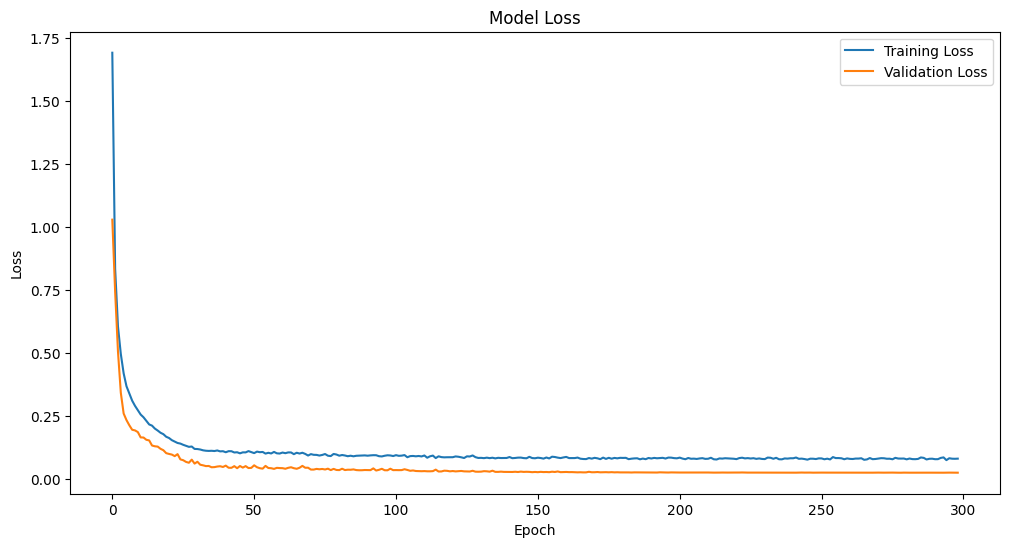

In [22]:
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

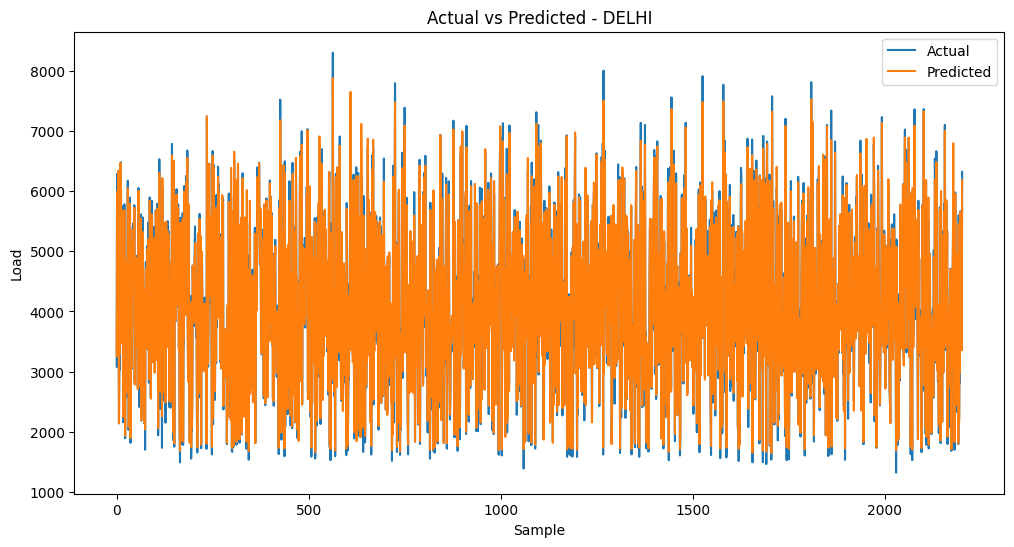

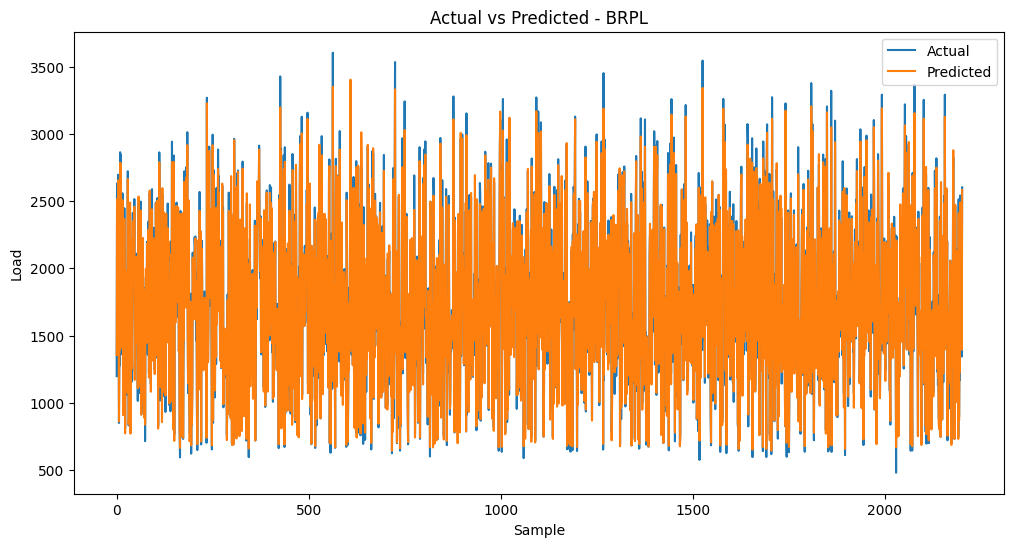

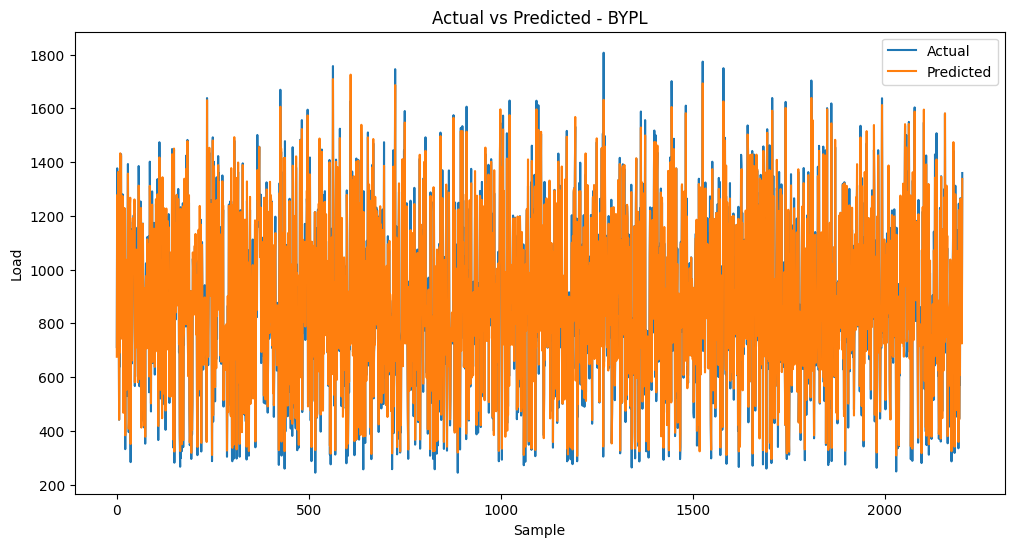

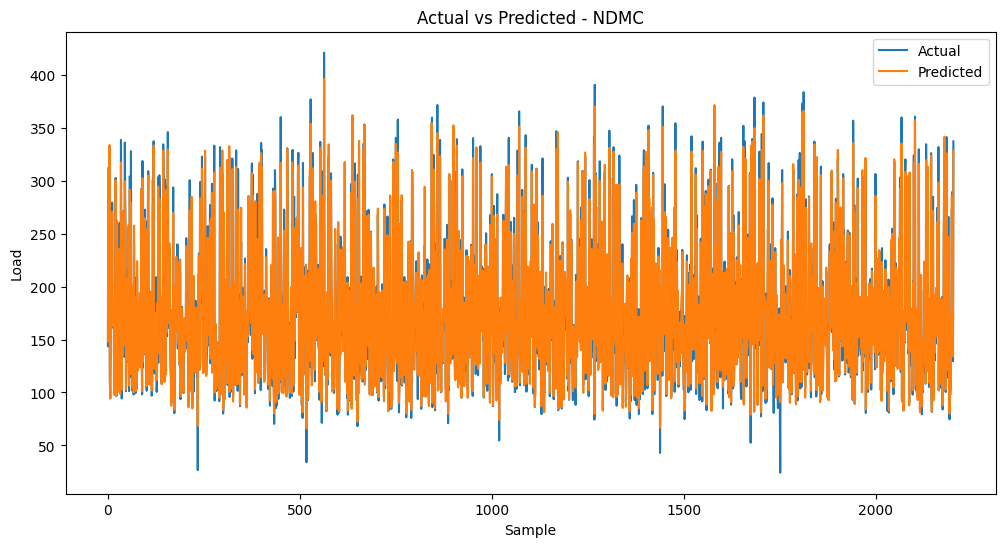

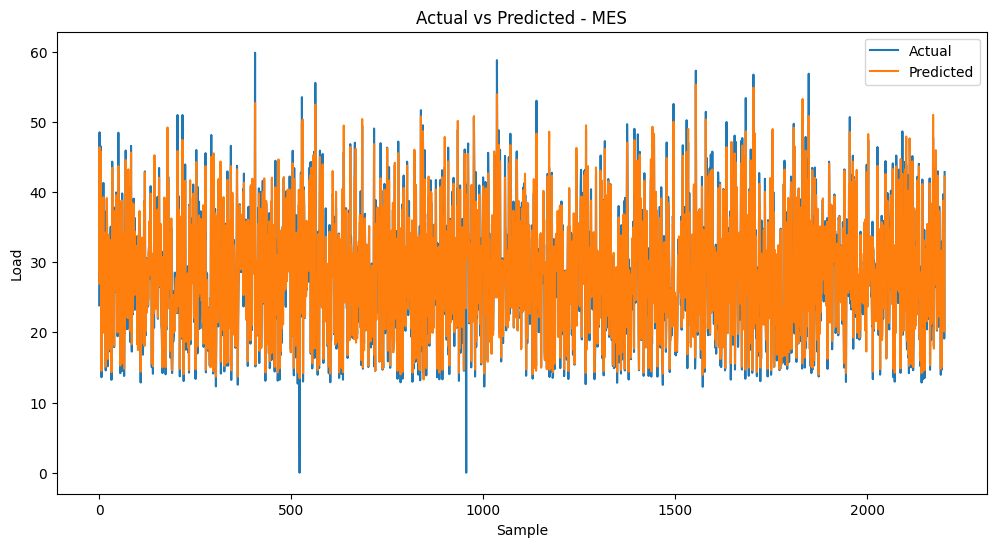

In [23]:
for i, target in enumerate(targets):
    plt.figure(figsize=(12, 6))
    plt.plot(y_test_inv[:, i], label='Actual')
    plt.plot(y_pred_inv[:, i], label='Predicted')
    plt.title(f'Actual vs Predicted - {target}')
    plt.xlabel('Sample')
    plt.ylabel('Load')
    plt.legend()
    plt.show()

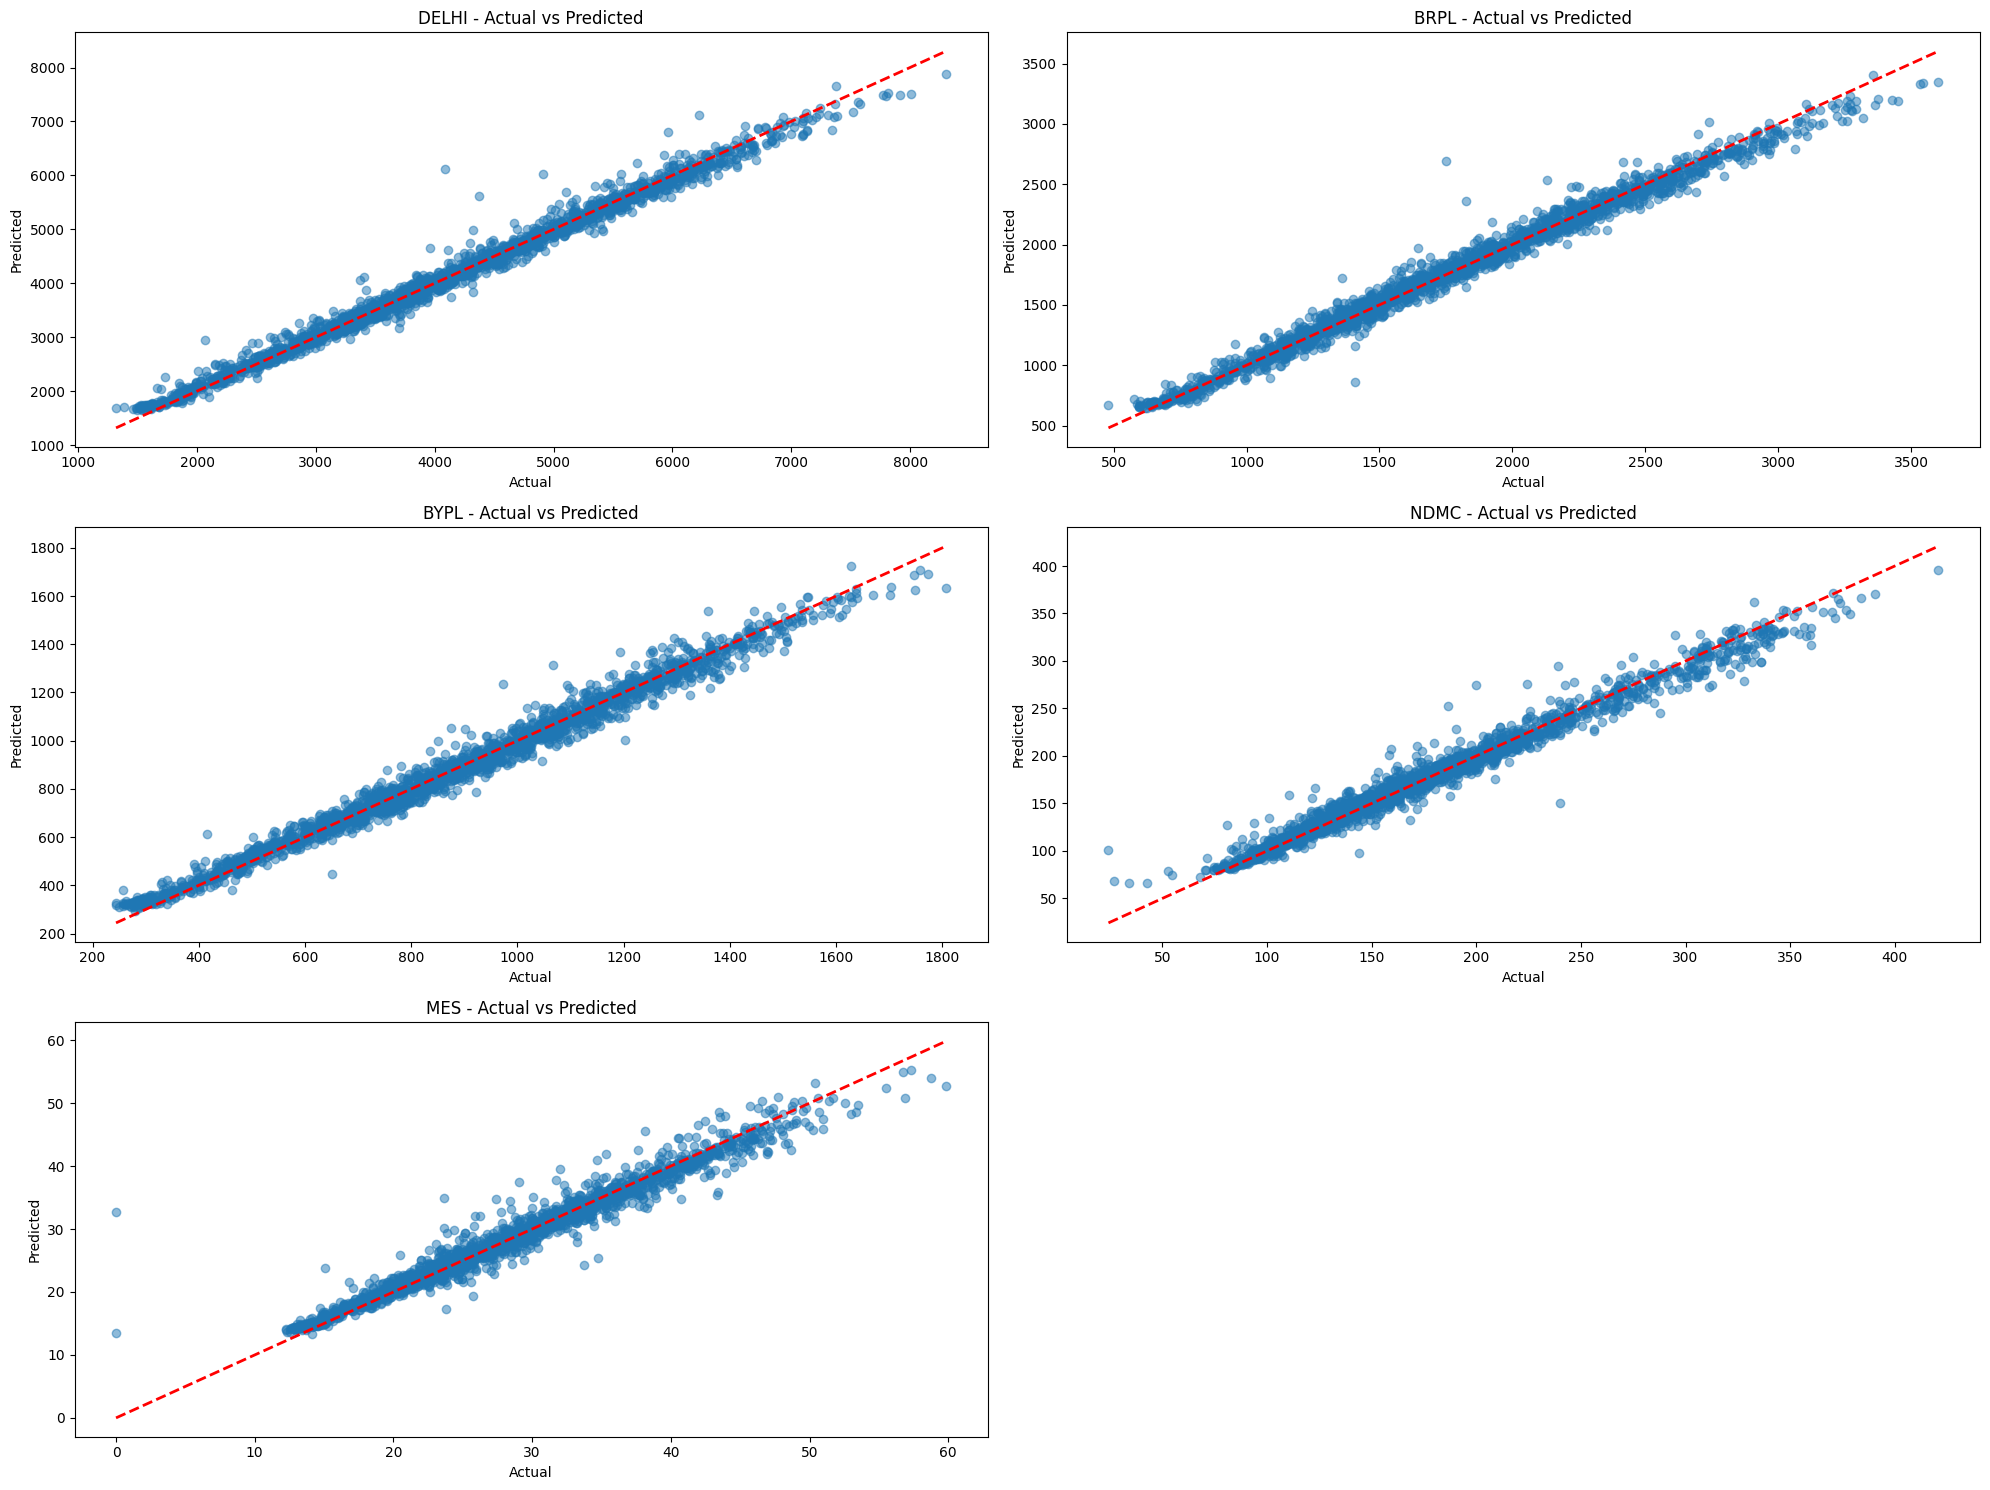

In [24]:
# Plot actual vs predicted scatter plot for all targets
plt.figure(figsize=(20, 15))
for i, target in enumerate(targets, 1):
    plt.subplot(3, 2, i)
    plt.scatter(y_test_inv[:, i-1], y_pred_inv[:, i-1], alpha=0.5)
    plt.plot([y_test_inv[:, i-1].min(), y_test_inv[:, i-1].max()], 
             [y_test_inv[:, i-1].min(), y_test_inv[:, i-1].max()], 'r--', lw=2)
    plt.xlabel('Actual')
    plt.ylabel('Predicted')
    plt.title(f'{target} - Actual vs Predicted')
plt.tight_layout()
plt.show()

In [25]:
def predict_loads_simple(input_features, preprocessor, model, scalers_y, numerical_features, categorical_features):
    # Preprocess the input features
    X_input = preprocessor.transform(input_features)
    
    # Reshape the input to (samples, time steps, features) format
    X_input = X_input.reshape((X_input.shape[0], 1, X_input.shape[1]))
    
    # Predict the target values (loads)
    y_pred = model.predict(X_input)
    
    # Inverse transform the predictions
    y_pred_inv = np.zeros_like(y_pred)
    targets = ['DELHI', 'BRPL', 'BYPL', 'NDMC', 'MES']
    
    for i, target in enumerate(targets):
        y_pred_inv[:, i] = scalers_y[target].inverse_transform(y_pred[:, i].reshape(-1, 1)).ravel()
    
    # Return the predicted loads as a dictionary
    predictions = {target: y_pred_inv[0, i] for i, target in enumerate(targets)}
    
    return predictions


In [26]:
import pandas as pd
from collections import deque

class HistoricalData:
    def __init__(self, max_history=24):
        self.targets = ['DELHI', 'BRPL', 'BYPL', 'NDMC', 'MES']
        self.history = {target: deque(maxlen=max_history) for target in self.targets}
    
    def add_data(self, data):
        """
        Add new data point to the history.
        data: dict with keys for each target
        """
        for target in self.targets:
            self.history[target].append(data[target])
    
    def get_lag_values(self):
        """
        Get lag_1 and lag_24 values for all targets.
        """
        lag_values = {}
        for target in self.targets:
            history = list(self.history[target])
            lag_values[f'{target}_lag_1'] = history[-1] if history else 0
            lag_values[f'{target}_lag_24'] = history[0] if len(history) == 24 else 0
        return lag_values

# Example usage:
historical_data = HistoricalData()

# Simulate adding 24 hours of data
for i in range(24):
    data = {target: i * 10 + j for j, target in enumerate(historical_data.targets)}
    historical_data.add_data(data)

# Get lag values
lag_values = historical_data.get_lag_values()
print(lag_values)

{'DELHI_lag_1': 230, 'DELHI_lag_24': 0, 'BRPL_lag_1': 231, 'BRPL_lag_24': 1, 'BYPL_lag_1': 232, 'BYPL_lag_24': 2, 'NDMC_lag_1': 233, 'NDMC_lag_24': 3, 'MES_lag_1': 234, 'MES_lag_24': 4}


In [32]:
# # Function to take user input for all features
# def getUserInput():
#     weekday = input("Enter the weekday (e.g., 'Monday'): ")
#     delhi = float(input("Enter the DELHI value: "))
#     brpl = float(input("Enter the BRPL value: "))
#     bypl = float(input("Enter the BYPL value: "))
#     ndmc = float(input("Enter the NDMC value: "))
#     mes = float(input("Enter the MES value: "))
#     temperature = float(input("Enter the temperature value: "))
#     humidity = float(input("Enter the humidity value: "))
#     windSpeed = float(input("Enter the wind speed value: "))
#     precipitation = float(input("Enter the precipitation value: "))
#     hour = float(input("Enter the hour (0-23): "))
#     dayOfWeek = float(input("Enter the day of the week (0-6): "))
#     month = float(input("Enter the month (1-12): "))
#     isWeekend = int(input("Is it a weekend? (1 for Yes, 0 for No): "))
#     delhiLag1 = float(input("Enter the DELHI lag 1 value: "))
#     delhiLag24 = float(input("Enter the DELHI lag 24 value: "))
#     brplLag1 = float(input("Enter the BRPL lag 1 value: "))
#     brplLag24 = float(input("Enter the BRPL lag 24 value: "))
#     byplLag1 = float(input("Enter the BYPL lag 1 value: "))
#     byplLag24 = float(input("Enter the BYPL lag 24 value: "))
#     ndmcLag1 = float(input("Enter the NDMC lag 1 value: "))
#     ndmcLag24 = float(input("Enter the NDMC lag 24 value: "))
#     mesLag1 = float(input("Enter the MES lag 1 value: "))
#     mesLag24 = float(input("Enter the MES lag 24 value: "))

#     # Return all features as an array
#     return np.array([[temperature, humidity, windSpeed, precipitation, delhiLag1, delhiLag24, brplLag1, brplLag24, byplLag1, byplLag24, ndmcLag1, ndmcLag24, mesLag1, mesLag24, hour, dayOfWeek, month, isWeekend]])

# # Function to make predictions based on user input
# def makePrediction():
#     userInput = getUserInput()

#     # Load scalers used in the original model training process
#     scaler = StandardScaler() 
#     scaledInput = scaler.fit_transform(userInput)
#     inputFeatures = np.array([[
#          brpl, bypl, ndmc, mes, temperature, humidity, windSpeed, 
#         precipitation, hour, dayOfWeek, month, isWeekend, delhiLag1, 
#         delhiLag24, brplLag1, brplLag24, byplLag1, byplLag24, ndmcLag1, 
#         ndmcLag24, mesLag1, mesLag24
#     ]])


#     reshapedInput = inputFeatures.reshape(1, -1)

#     # Make the prediction
#     prediction = model.predict(reshapedInput)

#     print("\nPredicted Output:", prediction)

# # Call the function to make a prediction
# makePrediction()

Enter the weekday (e.g., 'Monday'):  Monday
Enter the DELHI value:  56
Enter the BRPL value:  654
Enter the BYPL value:  654
Enter the NDMC value:  546
Enter the MES value:  654
Enter the temperature value:  42
Enter the humidity value:  5
Enter the wind speed value:  6
Enter the precipitation value:  0.0
Enter the hour (0-23):  5
Enter the day of the week (0-6):  6
Enter the month (1-12):  5
Is it a weekend? (1 for Yes, 0 for No):  1
Enter the DELHI lag 1 value:  45
Enter the DELHI lag 24 value:  4
Enter the BRPL lag 1 value:  654
Enter the BRPL lag 24 value:  56
Enter the BYPL lag 1 value:  56
Enter the BYPL lag 24 value:  56
Enter the NDMC lag 1 value:  5
Enter the NDMC lag 24 value:  65
Enter the MES lag 1 value:  65
Enter the MES lag 24 value:  5


NameError: name 'brpl' is not defined

In [29]:
# import pickle 
  
# # Save the trained model as a pickle string. 
# # saved_model = pickle.dumps(model) 
  
# # Load the pickled model 
# from_pickle = pickle.loads(saved_model) 
  

In [30]:
# X_test=pd.DataFrame({
#     'temperature': [25.0],
#     'humidity': [60],
#     'wind_speed': [3.5],
#     'precipitation': [0.0],
#     'hour': [14],
#     'weekday': [2],  
#     'month': [9],
#     'is_weekend': [0]  
# })
# from_pickle.predict(X_test) 

ValueError: Exception encountered when calling Sequential.call().

[1mInvalid input shape for input Tensor("data:0", shape=(1, 8), dtype=float32). Expected shape (None, 1, 49), but input has incompatible shape (1, 8)[0m

Arguments received by Sequential.call():
  • inputs=tf.Tensor(shape=(1, 8), dtype=float32)
  • training=False
  • mask=None